In [90]:
import nibabel as nib
from utils import load_config

config = load_config()
STORIES = config["STORIES"]

subject = 'sub-004'

# for story in STORIES:
#     # Load the NIfTI file
#     nifti_file = nib.load(f"/Users/gio/projects/ds_fmri/SUB_04_240925/{subject}_task-{story}_bold.nii.gz")

#     # read the data from nifti file
#     data = nifti_file.get_fdata()

#     print(f"The data has shape {data.shape}.")  

# # Load the NIfTI file
nifti_file = nib.load("/Users/gio/projects/ds_fmri/SUB_04_240925/sub_04_wip_fmri_stories_7_1.nii.gz")
# nifti_file = nib.load("/Users/gio/projects/ds_fmri/SUB_04_240925/sub-004_task-treasureisland_bold.nii.gz")

# read the data from nifti file
data = nifti_file.get_fdata()

print(f"The data has shape {data.shape}.")


OSError: Expected 1618176000 bytes, got 648374272 bytes from 
 - could the file be damaged?

In [93]:
for iscan in range(6, 12):
    nifti_file = nib.load(f"/Users/gio/projects/ds_fmri/SUB_04_240925/sub_04_wip_fmri_stories_{iscan}_1.nii.gz")
    hdr = nifti_file.header
    hdr.get_xyzt_units()
    data = nifti_file.get_fdata()

OSError: Expected 1618176000 bytes, got 889720832 bytes from 
 - could the file be damaged?

In [96]:
nifti_file = nib.load("/Users/gio/projects/ds_fmri/SUB_04_240925/sub_04_wip_fmri_stories_6_1.nii.gz")
hdr = nifti_file.header
hdr.get_xyzt_units()
print(nifti_file.shape)

(112, 112, 60, 1075)


In [100]:
print(1618176000 / 1075 / 112 / 112 / 60)
print(889720832 / 112 / 112 / 60 / 2)
print(648374272 / 112 / 112 / 60 / 2)


2.0
591.0666666666667
430.73333333333335


In [6]:
# read the data from nifti file
data = nifti_file.get_fdata()

print(f"The data has shape {data.shape}.")

The data has shape (112, 112, 60, 575).


In [84]:

import numpy as np
from utils import load_surf, load_config, butterworth_highpass, zscore, load_mp3, get_envelope, lanczosinterp2D

cfg = load_config()
DATADIR = cfg['DATA_DIR']
STIMDIR = cfg['STIM_DIR']
FIGDIR = cfg['FIG_DIR']

subject = 'sub-004'
story = 'undertheinfluence'

tr = 1.5

surf_data = load_surf(DATADIR, subject, story, 'L')

surf_data = butterworth_highpass(surf_data, tr, 0.01)

print(surf_data.shape)

# auditory envelope
audio, sr = load_mp3(STIMDIR, story)
audio_envelope = get_envelope(audio)

print(audio_envelope.shape[0] // sr)

window = 0.1
audio_envelope_avg = np.mean(audio_envelope[:len(audio_envelope) // int(sr * window) * int(sr * window)].reshape(-1, int(sr * window)), axis=1).reshape(-1, 1)

env = np.pad(audio_envelope_avg, ((int(12/window), int(20/window)), (0, 0)))

zEnv = zscore(lanczosinterp2D(env, np.arange(env.shape[0]) * window, np.arange(0, surf_data.shape[1]) * tr), axis=0).flatten()


(40962, 421)
597


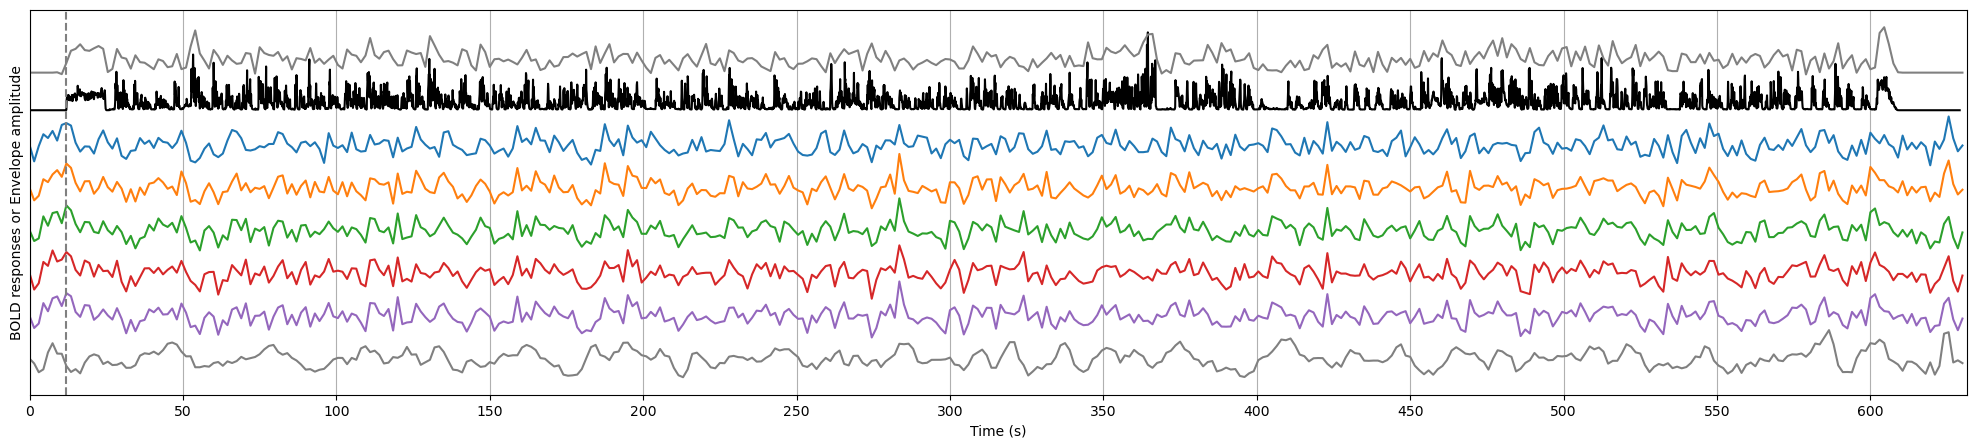

In [85]:
selvoxels = [1663, 16953, 11411, 3732, 25149]

import matplotlib.pyplot as plt

f = plt.figure(figsize=(25, 5))

f.clf()
colors = plt.cm.tab10.colors
ax = f.add_subplot(1,1,1)

for i, selvoxel in enumerate(selvoxels):
    ax.plot(np.arange(surf_data.shape[1]) * tr, zscore(surf_data[selvoxel, :]) - 5 * i, label=f'Vertex {selvoxel}', color=colors[i])

ax.plot(np.arange(env.shape[0]) * window, zscore(env[:, 0]) + 5, label='Auditory envelope', color='k')
ax.plot(np.arange(zEnv.shape[0]) * tr, zEnv + 10, label='Auditory envelope (interpolated)', color='gray')

ax.plot(np.arange(surf_data.shape[1]) * tr, zscore(np.mean(surf_data, axis=0)) - 25, label=f'Vertex {selvoxel}', color='gray')

ax.axvline(12, color='gray', linestyle='--', label='Stimulus onset')
ax.axvline(841, color='gray', linestyle='--', label='Stimulus offset')

ax.set_xlim(0, surf_data.shape[1] * tr)
ax.set_xticks(np.arange(0, surf_data.shape[1] * tr, 50))
ax.set_yticks([])

ax.set_xlabel("Time (s)")
ax.set_ylabel("BOLD responses or Envelope amplitude")
ax.grid()



(-0.5, 0.5)

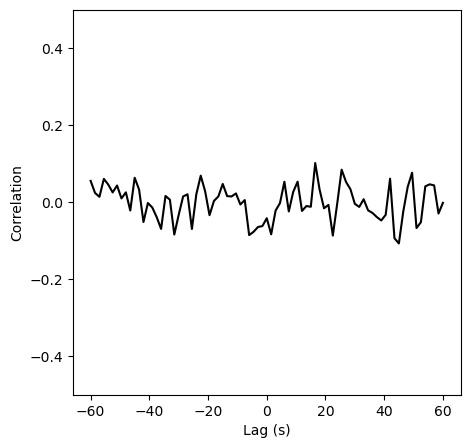

In [87]:
def lagcorr(x, y, maxlag=10):
    lags = np.arange(-maxlag, maxlag + 1)
    corrs = np.zeros(lags.shape)
    for i, lag in enumerate(lags):
        if lag < 0:
            corrs[i] = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag == 0:
            corrs[i] = np.corrcoef(x, y)[0, 1]
        else:
            corrs[i] = np.corrcoef(x[lag:], y[:-lag])[0, 1]
    
    return lags, corrs

lags, corrs = lagcorr(zEnv, surf_data[selvoxels[0]], maxlag=40)

f = plt.figure(figsize=(5,5))
f.clf()
ax = f.add_subplot(1,1,1)
ax.plot(lags * tr, corrs, "k-")
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Correlation")
ax.set_ylim(-0.5, 0.5)